# What is independent bath approximation and how to use it?

**Please read the [previous tutorial](https://nbviewer.org/github/TaoELi/cavity-md-ipi/blob/master/tutorials/single_molecule_reaction_vsc/single_molecule_reaction_vsc.ipynb) on single-molecule reaction under VSC before viewing this tutorial.**

Our goal in this tutorial is to efficiently use electronic structure theory to simulate collective vibrational strong coupling.

### Theory of CavMD

For a molecular system coupled to a multi-mode cavity, CavMD propagates the following equations of motion:

$$M_{j}\ddot{\mathbf{R}}_{j} = \mathbf{F}_{j}^{(0)} - \sum_{k,\lambda}\left(\varepsilon_{k,\lambda} \widetilde{q}_{k,\lambda}+ \frac{\varepsilon_{k,\lambda}^2}{m_{k,\lambda} \omega_{k,\lambda}^2} d_{g,\lambda}\right)\frac{\partial d_{g, \lambda}}{\partial \mathbf{R}_{j}}$$
$$m_{k,\lambda}\ddot{\widetilde{q}}_{k,\lambda} = - m_{k,\lambda}\omega_{k,\lambda}^2\widetilde{q}_{k,\lambda} -\varepsilon_{k,\lambda} d_{g,\lambda}$$
            
Here, $M_{j}$ and $\mathbf{R}_{j}$ denote the mass and position vector for the $j$-th atom, $\mathbf{F}_{j}^{(0)}$ denotes the nuclear force without the cavity for atom $j$; $\varepsilon_{k,\lambda} = \sqrt{m_{\lambda}\omega_{\lambda}^2/\Omega\epsilon_0}$ denotes the  light-matter coupling strength between each molecule and the cavity mode. $\widetilde{q}_{k,\lambda}$,  $\omega_{k,\lambda}$, and $m_{k,\lambda}$ denote the momentum, position operator, frequency, and auxiliary mass for each cavity photon mode with wave vector $\mathbf{k}$ ($k = |\mathbf{k}|$) and polarization direction defined by a unit vector $\mathbf{\xi}_\lambda$ (with $\mathbf{\xi}_\lambda \cdot \mathbf{k} = 0$). $d_{\text{g},\lambda}$ denotes the ground-state molecular dipole  of the whole molecular subsystem projected along the polarization direction $\mathbf{\xi}_\lambda$.

### What we need from electronic structure theory?

If first-principles electronic structure theory is used to perform calculations, as shown from the above equations, we need to calculate the following three quantities at each time step:

1. The nuclear forces without a cavity: $\mathbf{F}_{j}^{(0)}$;

2. The total molecular dipole moment: $d_{g,\lambda}$

3. The geometry derivatives of dipole moment: $\frac{\partial d_{g, \lambda}}{\partial \mathbf{R}_{j}}$

Because strong light-matter interactions are usually achieved when a large collection of molecules is coupled to the cavity, we really want to simulate a large ensemble of molecules inside the cavity. However, electronic structure theory does not like a lot of molecules: the computational scaling is usually $N^3$ or even larger. Hence, we need to take some approximations...

### The independent bath approximation

As shown in the picture below, under the independent bath approximation, we divide the total molecular system to $N_b$ independent subsystems. Between each subsystem, we assume there is no direct intermolecular interactions. Clearly, the independent bath approximation is a perfect approximation for (a) gas phase or (b) a dilute solution.

<img src="independent_bath_approx.png" alt="drawing" width="850"/>

Hence, it is possible to use electronic structure theory to independently calculate the nuclear forces, dipole and its derivatives for each subsystem. With this approximation, we can achieve the linear scaling: the computational cost is doubled if we increase the number of molecules in the system by a factor of two.

### How to use the independent bath approximation in CavMD?

With the experience of the last tutorial, we are now familiar with performing first-principles electronic structure calculations with CavMD using Psi4.

In [1]:
!ls dipder_calc/

cos_single.xyz	input_psi4_single.xml  photon_params.json  simu_two.xc.xyz
cos_two.xyz	input_psi4_two.xml     simu_single.xc.xyz


In the folder ```dipder_calc/```, there are two different input files: ```input_psi4_single.xml``` and ```input_psi4_two.xml```. The first input file performs first-principles CavMD for a single O=C=S molecule coupled to the cavity; the second input file performs the calculation for two O=C=S molecules coupled to the cavity with the same cavity parameters and **with the independent bath approximation**.

In the file ```input_psi4_two.xml```, the following piece of code controls how to use the independent bath approximation:

```xml
  <ffcavph name='psi4'>
      <input_xyz_filename> cos_two.xyz </input_xyz_filename>
      <grad_method> hf/6-31g </grad_method>
      <output_file> OUT_2.dat </output_file>
      <memory_usage> 4 gb </memory_usage>
      <numpy_memory> 2 </numpy_memory>
      <nthread> 1 </nthread>
      <n_independent_bath> 2 </n_independent_bath>
  </ffcavph>
```

More specifically, 
```xml
<n_independent_bath> 2 </n_independent_bath>
```
states that we will take two independent baths, i.e., we will separate the whole molecular system to two parts. The input xyz file for the simulation is ```cos_two.xyz```.

In [2]:
! cat dipder_calc/cos_two.xyz

8

       C -1.59952e-01  7.73417e-15 -3.30660e-15
       O -1.30437e+00 -1.37101e-15  3.69725e-15
       S  1.46432e+00 -6.36316e-15 -3.90655e-16
       C -1.59952e-01  7.73417e-15 -3.30660e-15
       O -1.30437e+00 -1.37101e-15  3.69725e-15
       S  1.46432e+00 -6.36316e-15 -3.90655e-16
       L  0.10000e+00  0.00000e+00  0.00000e+00
       L  0.00000e+00  0.00000e+00  0.00000e+00


With the independent bath approximation, the first 3 atoms belong to the first bath, and the next 3 atoms belong to the second bath. The molecules in different baths can overlap or not. **We always need the total number of molecular atoms (excluding photons ```L```) to be an integer times of the number of the baths**.

With the independent bath approximation defined, it is easy to run CavMD. Please go to the folder ```dipder_calc/``` and simply runs the CavMD input file with ```i-pi input_psi4_two.xml``` or ```i-pi input_psi4_single.xml```. Each job runs simulation for 500 time steps. You would find the computational cost of the first one is about two times of the second one, and we really achieve the linear scaling now.

Below is a piece of code to analyze the real-time Rabi oscillations and frequency-domain Rabi splitting from the photon coordinate trajectory.

In [3]:
# We now analysis the data

import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda

def get_cavity_coordinate(xyz_filename, dt_fs=0.5):
    # try to load the xyz file using MDA
    traj = mda.Universe(xyz_filename)
    frames = traj.trajectory
    nframes = len(frames)
    print("In %s nframes = %d" %(xyz_filename, nframes))
    xc_traj = []
    for idx, ts in enumerate(frames):
        current_coord = ts._pos.copy()
        xc_traj.append(current_coord[-2,0])
    xc_traj = np.array(xc_traj)
    t_lst = np.array([dt_fs*i for i in range(xc_traj.size)])
    return t_lst, xc_traj

/home/tao/.local/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: L
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In dipder_calc/simu_single.xc.xyz nframes = 501
In dipder_calc/simu_two.xc.xyz nframes = 501


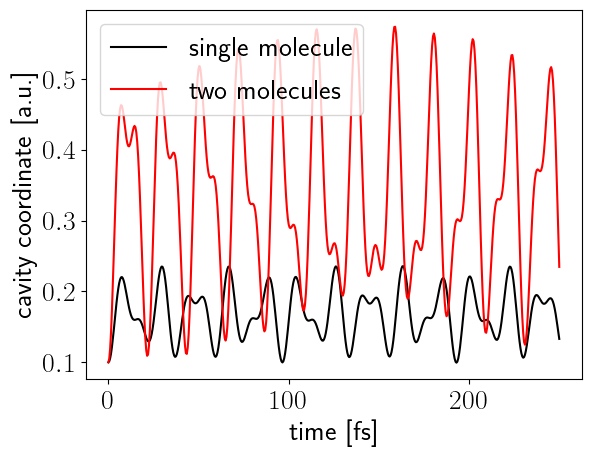

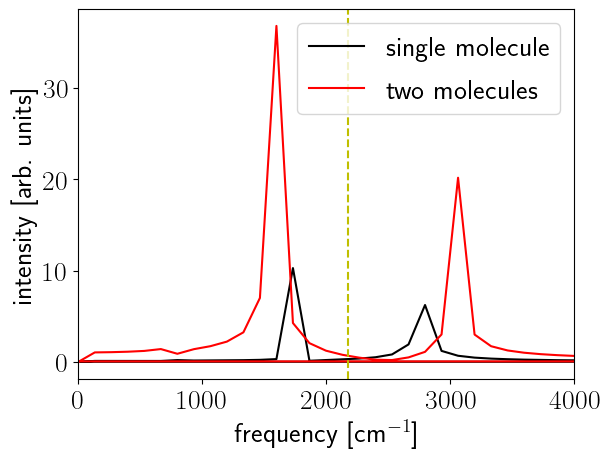

In [4]:
# filename for a single COS molecule coupled to the cavity
filename_single = "dipder_calc/simu_single.xc.xyz"
# filename for two COS molecules coupled to the cavity
filename_two = "dipder_calc/simu_two.xc.xyz"

t_single, xc_single = get_cavity_coordinate(filename_single)
t_two, xc_two = get_cavity_coordinate(filename_two)

# Plot the time-domain Rabi oscillations of the cavity coordinate

label_size=20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

ax = plt.subplot()
ax.plot(t_single, xc_single, c="k", label="single molecule")
ax.plot(t_two, xc_two, c="r", label="two molecules")
ax.set_xlabel("time [fs]", fontsize=label_size)
ax.set_ylabel("cavity coordinate [a.u.]", fontsize=label_size)
ax.legend(fontsize=label_size)
plt.show()


# The frequency domain distribution
fs2au = 41.341374575
au2cminv = 1.0 / 219474.63

sp_single = np.abs(np.fft.fft(xc_single - np.mean(xc_single)))
freq_single = np.fft.fftfreq(t_single.size, d=0.5*fs2au) / au2cminv * 2.0 * np.pi
sp_two = np.abs(np.fft.fft(xc_two - np.mean(xc_two)))
freq_two = np.fft.fftfreq(t_two.size, d=0.5*fs2au) / au2cminv * 2.0 * np.pi

# Plot the frequency-domain Rabi splitting
ax = plt.subplot()
ax.plot(freq_single, sp_single, c="k", label="single molecule")
ax.plot(freq_two, sp_two, c="r", label="two molecules")
ax.axvline(x=2178, c="y", linestyle="--")
ax.set_xlabel("frequency [cm$^{-1}$]", fontsize=label_size)
ax.set_ylabel("intensity [arb. units]", fontsize=label_size)
ax.set_xlim(0, 4000)
ax.legend(fontsize=label_size)
plt.show()

We clearly see that with two molecules, the Rabi splitting is about $\sqrt{2}$ times of the single-molecule case.

### How to further accelerate the calculation? Avoid calculating dipole derivatives!

Recall that to run CavMD, we need the following three quantities at each time step:

1. The nuclear forces without a cavity: $\mathbf{F}_{j}^{(0)}$;

2. The total molecular dipole moment: $d_{g,\lambda}$

3. The geometry derivatives of dipole moment: $\frac{\partial d_{g, \lambda}}{\partial \mathbf{R}_{j}}$

Among the above three quantities, the dipole derivatives are the most time-consuming one to calculate. When molecules just move near their equilibrium geometries, their dipole derivatives can be approximated as constants, equaling to the partial charges of the nuclei, i.e.,

$$\frac{\partial d_{g, \lambda}}{\partial x_{j}} \approx Q_j \delta_{\lambda,x}$$
$$\frac{\partial d_{g, \lambda}}{\partial y_{j}} \approx Q_j \delta_{\lambda,y}$$
$$\frac{\partial d_{g, \lambda}}{\partial z_{j}} \approx Q_j \delta_{\lambda,z}$$
where $Q_j$ denotes the partial charge of atom $j$. This approximation can also be taken in CavMD. For example, the folder ```dipder_skip/``` contains the same calculations as above but assuming fixed partial charges.

In the file ```dipder_skip/input_psi4_two.xml```, the input file looks like the follows:
```xml
  <ffcavph name='psi4'>
      <input_xyz_filename> cos_two.xyz </input_xyz_filename>
      <grad_method> hf/6-31g </grad_method>
      <output_file> OUT_2.dat </output_file>
      <memory_usage> 4 gb </memory_usage>
      <numpy_memory> 2 </numpy_memory>
      <nthread> 1 </nthread>
      <n_independent_bath> 2 </n_independent_bath>
      <qm_charge_array> [0.6512, -0.3256, -0.3256] </qm_charge_array>
  </ffcavph>
```
where we define 
```
      <qm_charge_array> [0.6512, -0.3256, -0.3256] </qm_charge_array>
```
to assign a positive charge ```0.6512``` to the ```C``` atom, and the same negative charges to the rest ```O``` and ```S``` atoms. Note that here we just need to include the charge array for a single independent bath, and we always **assume identical copies of molecules in each bath**.

After simulating the two jobs in the folder ```dipder_skip/``` (it should be much faster than the two jobs above), we can also plot the IR spectrum to compare:

In dipder_skip/simu_single.xc.xyz nframes = 501
In dipder_skip/simu_two.xc.xyz nframes = 501


/home/tao/.local/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: L
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


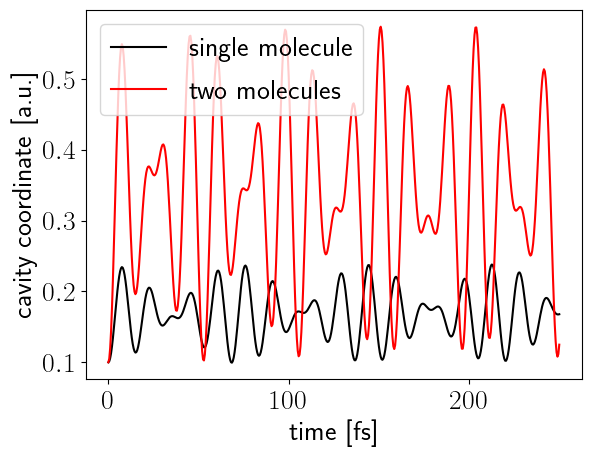

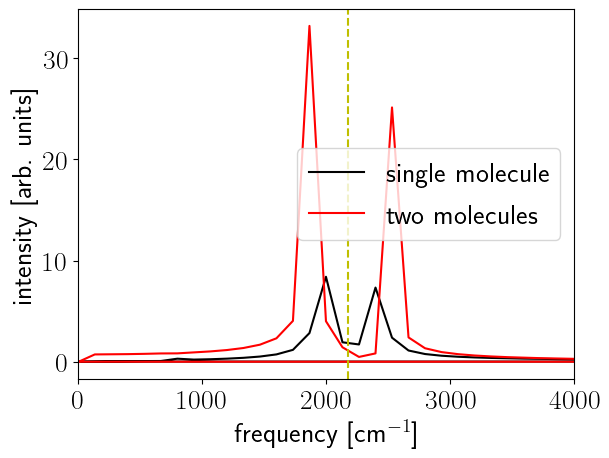

In [5]:
# filename for a single COS molecule coupled to the cavity
filename_single = "dipder_skip/simu_single.xc.xyz"
# filename for two COS molecules coupled to the cavity
filename_two = "dipder_skip/simu_two.xc.xyz"

t_single, xc_single = get_cavity_coordinate(filename_single)
t_two, xc_two = get_cavity_coordinate(filename_two)

# Plot the time-domain Rabi oscillations of the cavity coordinate

label_size=20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

ax = plt.subplot()
ax.plot(t_single, xc_single, c="k", label="single molecule")
ax.plot(t_two, xc_two, c="r", label="two molecules")
ax.set_xlabel("time [fs]", fontsize=label_size)
ax.set_ylabel("cavity coordinate [a.u.]", fontsize=label_size)
ax.legend(fontsize=label_size)
plt.show()


# The frequency domain distribution
fs2au = 41.341374575
au2cminv = 1.0 / 219474.63

sp_single = np.abs(np.fft.fft(xc_single - np.mean(xc_single)))
freq_single = np.fft.fftfreq(t_single.size, d=0.5*fs2au) / au2cminv * 2.0 * np.pi
sp_two = np.abs(np.fft.fft(xc_two - np.mean(xc_two)))
freq_two = np.fft.fftfreq(t_two.size, d=0.5*fs2au) / au2cminv * 2.0 * np.pi

# Plot the frequency-domain Rabi splitting
ax = plt.subplot()
ax.plot(freq_single, sp_single, c="k", label="single molecule")
ax.plot(freq_two, sp_two, c="r", label="two molecules")
ax.axvline(x=2178, c="y", linestyle="--")
ax.set_xlabel("frequency [cm$^{-1}$]", fontsize=label_size)
ax.set_ylabel("intensity [arb. units]", fontsize=label_size)
ax.set_xlim(0, 4000)
ax.legend(fontsize=label_size)
plt.show()

Clearly, we see some differences in the spectrum, showing that **the exact values of dipole derivatives are important for simulations**.

### Additional tips

1. Psi4 does not do calculations for small molecules with very high symmetry very well. Please try to study molecules with low symmetry using the Psi4 gradients.


2. The independent bath approximation with Psi4 is not parallel very well. It can be used for demonstration or small calculations, but perhaps not the large-scale calculations.

## Citations

If you find this feature helpful for your research, please cite 

- Li, T. E., Hammes-Schiffer, S.  QM/MM Modeling of Vibrational Polariton Induced Energy Transfer and Chemical Dynamics. [J. Am. Chem. Soc. 2022, accepted](https://arxiv.org/abs/2212.02322). [additional code](https://github.com/TaoELi/cavmd_examples_qmmm)

If you directly use the code, please also cite the original i-pi and psi4 papers:

- Kapil, V., Rossi, M., Marsalek, O., Petraglia, R., Litman, Y., Spura, T., … Ceriotti, M., I-PI 2.0: A universal force engine for advanced molecular simulations. [Comput. Phys. Commun., 2019, 236, 214–223.](https://doi.org/10.1016/j.cpc.2018.09.020)


- Smith, D. G. A., Burns, L. A., Simmonett, A. C., Parrish, R. M., Schieber, M. C., Galvelis, R., … Sherrill, C. D. (2020). Psi4 1.4: Open-source software for high-throughput quantum chemistry. The Journal of Chemical Physics, 152(18), 184108. https://doi.org/10.1063/5.0006002